# Predictive Power of Imbalance on Future Price Movements

- This notebook explores the relationship between price imbalance (an imbalance in the supply and demand of a product or service) and future price movements.

We work with the order book data of Bouygues on year 2011

The Imbalance formula : 

$$Imb = \frac{Q_{ask}-Q_{bid}}{Q_{ask}+Q_{bid}}$$

Where $Q_{ask}$ and $Q_{bid}$ are the order quantities at the bid and the ask of the order book.

We compute for various horizons $h$ (between 1 and 10) the difference between the current price and the future price at horizon $h$ in basis points (bps).

$$diff(h)=100\times100\times\frac{P_{t+h}-P_t}{P_t}$$

From this, we deduce the predictive power of imbalance on $diff(h)$ based on different values of $h$. We then analyse the relationship for different horizons h.

### Import : 

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

Other orderbook can be consider, we choose Bouygues : 

In [165]:

#df_amazon  = pd.read_hdf("AMAZON.h5")
#df_apple  = pd.read_hdf("APPLE.h5")
df_bouygues  = pd.read_hdf("BOUYGUES.h5")
#df_canon  = pd.read_hdf("CANON.h5")
#df_google  = pd.read_hdf("GOOGLE.h5")
#df_lvmh  = pd.read_hdf("LVMH.h5")
#df_panasonic  = pd.read_hdf("PANASONIC.h5")
#df_sanofi  = pd.read_hdf("SANOFI.h5")
#df_sony  = pd.read_hdf("SONY.h5")
#df_total  = pd.read_hdf("TOTAL.h5")

In [166]:
df_bouygues.head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-01-03 09:00:01.921,32.5,200,32.39,32.475,5000,55300,2
2011-01-03 09:00:01.921,32.5,50,32.39,32.475,5000,55300,2
2011-01-03 09:00:01.921,32.5,45,32.39,32.475,5000,55300,2
2011-01-03 09:00:01.921,32.5,5,32.39,32.475,5000,55300,2
2011-01-03 09:00:01.921,32.5,6,32.39,32.475,5000,55300,2


We choose to analyze the data from the year 2011.

In [167]:
start_time = pd.Timestamp('2011-01-01 00:00:00')
end_time = pd.Timestamp('2011-12-31 23:59:00')

def select_rows(df, start_time, end_time):
  return df[(df.index >= start_time) & (df.index < end_time)]

df_bouygues_2011 = select_rows(df_bouygues, start_time, end_time)
df_bouygues_2011

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-01-03 09:00:01.921,32.500,200,32.390,32.475,5000,55300,2
2011-01-03 09:00:01.921,32.500,50,32.390,32.475,5000,55300,2
2011-01-03 09:00:01.921,32.500,45,32.390,32.475,5000,55300,2
2011-01-03 09:00:01.921,32.500,5,32.390,32.475,5000,55300,2
2011-01-03 09:00:01.921,32.500,6,32.390,32.475,5000,55300,2
...,...,...,...,...,...,...,...
2011-12-30 17:29:53.187,24.280,383,24.275,24.280,27700,303300,1
2011-12-30 17:29:53.195,24.280,289,24.275,24.280,27700,303300,1
2011-12-30 17:29:55.065,24.275,277,24.275,24.280,77700,206100,-1


We add the rounded signed imbalance to 
1
0
−
1
10 
−1
 .

In [168]:
def imbalance(df0) :
  df = df0.copy()
  df['Imbalance'] = ((df['AskQty'] - df['BidQty']) / (df['AskQty'] + df['BidQty'])).round(decimals=1)
  return df

new_df_bouygues = imbalance(df_bouygues_2011)
new_df_bouygues.head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign,Imbalance
Time,,,,,,,,
2011-01-03 09:00:01.921,32.5,200,32.39,32.475,5000,55300,2,0.8
2011-01-03 09:00:01.921,32.5,50,32.39,32.475,5000,55300,2,0.8
2011-01-03 09:00:01.921,32.5,45,32.39,32.475,5000,55300,2,0.8
2011-01-03 09:00:01.921,32.5,5,32.39,32.475,5000,55300,2,0.8
2011-01-03 09:00:01.921,32.5,6,32.39,32.475,5000,55300,2,0.8


We include 
d
i
f
f
(
h
)
diff(h) for 
h
h ranging from 1 to 10.

In [169]:
def add_diff(df0, h) :
  df = df0.copy()
  df[f'diff({h})'] = -100 * 100 * df['TradedPrice'].diff(periods=h) / df['TradedPrice']
  return df

for k in range(1, 11) :
  new_df_bouygues = add_diff(new_df_bouygues, k)

new_df_bouygues.head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign,Imbalance,diff(1),diff(2),diff(3),diff(4),diff(5),diff(6),diff(7),diff(8),diff(9),diff(10)
Time,,,,,,,,,,,,,,,,,,
2011-01-03 09:00:01.921,32.5,200,32.39,32.475,5000,55300,2,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 09:00:01.921,32.5,50,32.39,32.475,5000,55300,2,0.8,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 09:00:01.921,32.5,45,32.39,32.475,5000,55300,2,0.8,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 09:00:01.921,32.5,5,32.39,32.475,5000,55300,2,0.8,-0.0,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 09:00:01.921,32.5,6,32.39,32.475,5000,55300,2,0.8,-0.0,-0.0,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
def reglin(x, y):
    x = x.reshape(-1, 1)
    model = LinearRegression(fit_intercept=True).fit(x, y)
    return model.coef_[0], model.intercept_, model.score(x, y)

We group the price movements for a given horizon 
h based on the value of the Imbalance and perform a  linear regression:

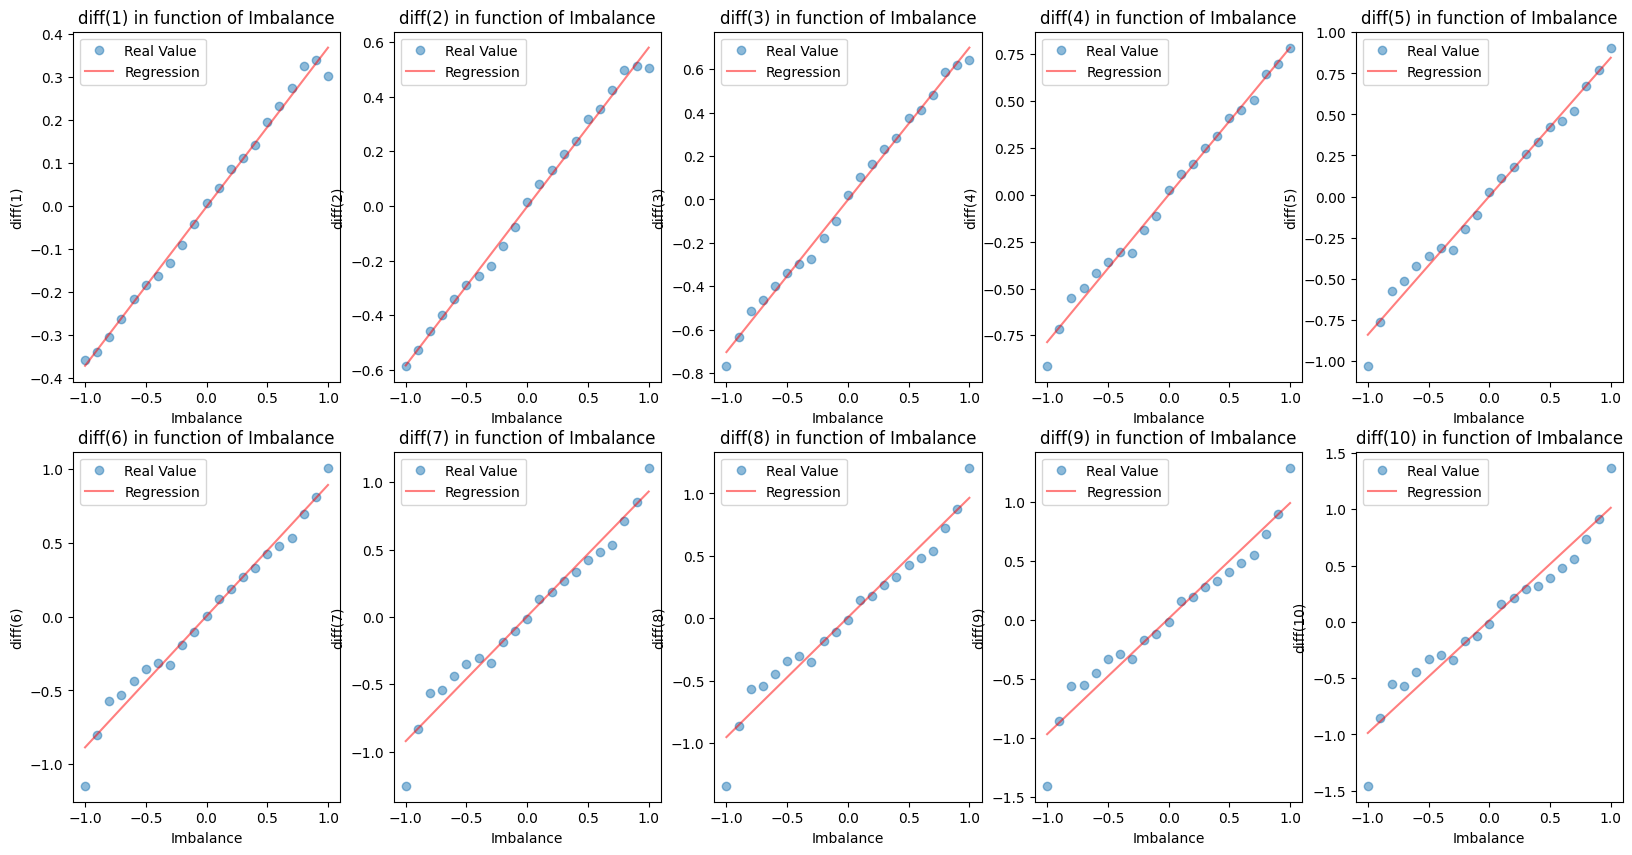

In [171]:
scores = {}

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for k in range(10) :
  df = new_df_bouygues.groupby('Imbalance')[f'diff({k+1})'].mean()
  df.plot(ax=axes[k//5][k%5], ylabel=f'diff({k+1})', label='Real Value', marker='o', linestyle='None', alpha=0.5)
  coef, intercept, score = reglin(np.array(df.index), np.array(df))
  axes[k//5][k%5].plot(np.array(df.index), coef * np.array(df.index) + intercept, color='red', label='Regression', alpha=0.5)
  axes[k//5][k%5].legend()
  axes[k//5][k%5].set_title(f'diff({k+1}) in function of Imbalance')
  scores[f'diff({k+1})'] = score

plt.show()

- We visually observe that Imbalance is a good predictor of future price movements. We see a linear relationship for small $h$. However, for larger $h$ values (such as 7, 8, 9, 10), the relationship is no longer strictly linear (it resembles more of a tangent function).

- As expected, when there is a large quantity at the Ask (many sellers), the price decreases. Conversely, when there are many people at the Bid (many buyers), the price increases.

Let's examine the values of the coefficient of determination $R^2$.

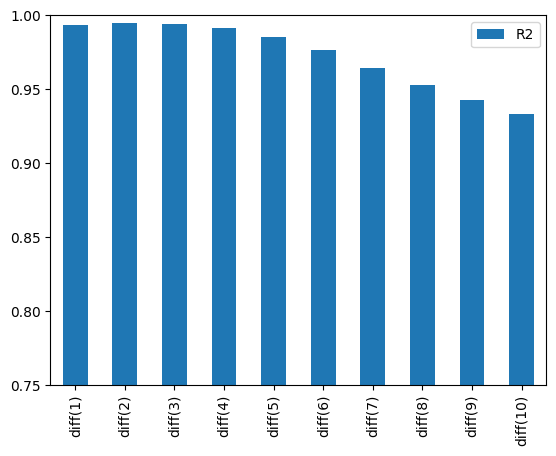

In [172]:
pd.DataFrame.from_dict(scores, orient='index', columns=['R2']).plot.bar()
plt.ylim(0.75, 1.0)
plt.show()

In [173]:
for score in scores:
    print(f"Score Linear Regression pour {score}: {scores[score].round(4)}")

Score Linear Regression pour diff(1): 0.9932
Score Linear Regression pour diff(2): 0.9948
Score Linear Regression pour diff(3): 0.9943
Score Linear Regression pour diff(4): 0.9913
Score Linear Regression pour diff(5): 0.9854
Score Linear Regression pour diff(6): 0.9769
Score Linear Regression pour diff(7): 0.9646
Score Linear Regression pour diff(8): 0.9532
Score Linear Regression pour diff(9): 0.9426
Score Linear Regression pour diff(10): 0.9335


We observe that:
- The accuracy of the linear regression decreases as the number of steps (h) increases.

Let's attempt to enhance this regression by utilizing a neural network and incorporating additional features to predict the subsequent price.

---

# 2. Enhancing Previous Results with Neural Networks and Memory of Transaction Signs

We had the following variables : 

* the sign of the last 10 transactions (`TradedSign`),
* the normalized transaction volume by ATS (Average Trading Size),
* the volumes at the best bid and ask.

We seek to predict, utilizing the signs of the last 10 transactions, volumes at the best bid and ask, normalized transaction volume, and imbalance, the future increase ($diff(h)$) in price by employing a MLP (Multilayer Perceptron) with `tensorflow`.

### a. Import of PyTorch

In [174]:
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim

### b. Creating a Training Set and Test Set for the Model

- The imbalance and diff(h) have already been calculated in part 1.

- Let's add the sign of the last 10 transactions:

In [175]:
df_NN = new_df_bouygues.copy()
for k in range(1, 11):
    df_NN[f'TradedSgn({k})'] = df_NN['TradedSign'].shift(k)

#df_NN.dropna(inplace=True)
df_NN.fillna(0, inplace=True)
df_NN.head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign,Imbalance,diff(1),diff(2),...,TradedSgn(1),TradedSgn(2),TradedSgn(3),TradedSgn(4),TradedSgn(5),TradedSgn(6),TradedSgn(7),TradedSgn(8),TradedSgn(9),TradedSgn(10)
Time,,,,,,,,,,,,,,,,,,,,,
2011-01-03 09:00:01.921,32.5,200,32.39,32.475,5000,55300,2,0.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03 09:00:01.921,32.5,50,32.39,32.475,5000,55300,2,0.8,-0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03 09:00:01.921,32.5,45,32.39,32.475,5000,55300,2,0.8,-0.0,-0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03 09:00:01.921,32.5,5,32.39,32.475,5000,55300,2,0.8,-0.0,-0.0,...,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03 09:00:01.921,32.5,6,32.39,32.475,5000,55300,2,0.8,-0.0,-0.0,...,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


- We add the l'ATS : 

In [176]:
average_trading_size = df_NN['TradedQty'].mean()
df_NN['NormTradedQty'] = df_NN['TradedQty'] / average_trading_size
df_NN.fillna(0, inplace=True)
df_NN.head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign,Imbalance,diff(1),diff(2),...,TradedSgn(2),TradedSgn(3),TradedSgn(4),TradedSgn(5),TradedSgn(6),TradedSgn(7),TradedSgn(8),TradedSgn(9),TradedSgn(10),NormTradedQty
Time,,,,,,,,,,,,,,,,,,,,,
2011-01-03 09:00:01.921,32.5,200,32.39,32.475,5000,55300,2,0.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.992454
2011-01-03 09:00:01.921,32.5,50,32.39,32.475,5000,55300,2,0.8,-0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.248113
2011-01-03 09:00:01.921,32.5,45,32.39,32.475,5000,55300,2,0.8,-0.0,-0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223302
2011-01-03 09:00:01.921,32.5,5,32.39,32.475,5000,55300,2,0.8,-0.0,-0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024811
2011-01-03 09:00:01.921,32.5,6,32.39,32.475,5000,55300,2,0.8,-0.0,-0.0,...,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029774


- We project our dataframe on the columns

In [177]:
X = df_NN[[ 'Imbalance', 'NormTradedQty', 
            'AskQty',
            'BidQty',
            'TradedSgn(1)', 'TradedSgn(2)', 
            'TradedSgn(3)', 'TradedSgn(4)', 
            'TradedSgn(5)', 'TradedSgn(6)', 
            'TradedSgn(7)', 'TradedSgn(8)', 
            'TradedSgn(9)', 'TradedSgn(10)']]

Y_s = new_df_bouygues[[f'diff({k})' for k in range(1, 11)]]
# We drop the 20 first and 20 last lines to avoid NaN (Otherwise the NN training crashes)
X = X[20:-20]
Y_s = Y_s[20:-20]


X.head()


,Imbalance,NormTradedQty,AskQty,BidQty,TradedSgn(1),TradedSgn(2),TradedSgn(3),TradedSgn(4),TradedSgn(5),TradedSgn(6),TradedSgn(7),TradedSgn(8),TradedSgn(9),TradedSgn(10)
Time,,,,,,,,,,,,,,
2011-01-03 09:00:01.923,0.8,0.387057,55300,5000,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2011-01-03 09:00:01.923,0.8,0.124057,55300,5000,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2011-01-03 09:00:01.923,0.8,0.059547,55300,5000,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2011-01-03 09:00:01.923,0.8,0.396981,55300,5000,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2011-01-03 09:00:01.923,0.8,0.248113,55300,5000,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


- We group the $Y$ values to predict into $Y_s$. Thus, $Y_s$ contains the 10 columns $diff(1), ... diff(10)$ of data to predict with the rows of $X$


- We split the data into a training set and a test set using train_test_split

- Then we normalize $X$ using the scalers of $X_{train}$ and $Y$ using the scalers of $Y_{train}$


In [178]:
from sklearn.model_selection import train_test_split

# We create the train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_s, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
Y_train = torch.tensor(Y_train.values, dtype=torch.float32)
Y_test = torch.tensor(Y_test.values, dtype=torch.float32)

# Generate the scalers
X_scaler = StandardScaler()
Y_scaler_s = [StandardScaler() for _ in range(10)] # We have 1 scaler for each diff(h)

# We fit the scalers
X_scaler.fit(X_train)
for k in range(10):
    Y_scaler_s[k].fit(Y_train[:, k].reshape(-1, 1))

# We transform the data
X_train_norm = X_scaler.transform(X_train)
X_test_norm = X_scaler.transform(X_test)
Y_train_norm_s = [Y_scaler_s[k].transform(Y_train[:, k].reshape(-1, 1)).flatten() for k in range(10)]
Y_test_norm_s = [Y_scaler_s[k].transform(Y_test[:, k].reshape(-1, 1)).flatten() for k in range(10)]
                 
X_train_norm = torch.tensor(X_train_norm, dtype=torch.float32)
X_test_norm = torch.tensor(X_test_norm, dtype=torch.float32)
Y_train_norm_s = [torch.tensor(Y_train_norm_s[k], dtype=torch.float32) for k in range(10)]
Y_test_norm_s = [torch.tensor(Y_test_norm_s[k], dtype=torch.float32) for k in range(10)]

In [179]:
X_train_norm.shape

torch.Size([1300935, 14])

We have 14 features and about 1.3M data points.

### c. We build the Neuronal Network

- ### Declaration of the NN: 

Given the shape of the curve to predict, which is relatively simple, it should not be necessary to train a very complex network.

After several tests of architecture, a network with one hidden layer of size 32 with a TanH activation function is sufficient to outperform linear regression.


In [194]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedForwardNet, self).__init__()
        hidden_size1 = 32
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size1, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
       

        return x
    
criterion = nn.MSELoss()

In [195]:
ep_list = {}
train_loss_list = {}
test_loss_list = {}
for k in range(10):
    ep_list[k] = []
    train_loss_list[k] = []
    test_loss_list[k] = []

### d. We then train the NN

- Training function of the NN :

In [196]:
def train_model_k(k, model, X_train, Y_train, X_test, Y_test, epochs=100, lr=0.1):
    # train of the k-th model.
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        Y_pred = model(X_train)
        #print(Y_pred.reshape(-1,1))
        
        loss = criterion(Y_pred.reshape(-1,1), Y_train.reshape(-1,1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            model.eval()
            Y_test_pred = model(X_test)
            test_loss = criterion(Y_test_pred.reshape(-1,1), Y_test.reshape(-1,1))
            print(f'Epoch {epoch} - Train Loss: {loss.item()} - Test loss: {test_loss.item()}')

            ep_list[k].append(epoch)
            train_loss_list[k].append(loss.item())
            test_loss_list[k].append(test_loss.item())

    return model

model_list = [FeedForwardNet(X_train_norm.shape[1], 1) for _ in range(10)]

- This lasts about ~ 7 min

In [197]:
from tqdm import tqdm

for k in tqdm(range(10), desc='Entrainement du NN(h) avec h -> ', unit='model'):
    model_list[k] = train_model_k(k, model_list[k], X_train_norm, Y_train_norm_s[k], X_test_norm, Y_test_norm_s[k])


Entrainement du NN(h) avec h -> :   0%|          | 0/10 [00:00<?, ?model/s]

Epoch 0 - Train Loss: 1.1053094863891602 - Test loss: 2.445988178253174
Epoch 10 - Train Loss: 1.0730922222137451 - Test loss: 0.9943301677703857
Epoch 20 - Train Loss: 1.043262243270874 - Test loss: 1.0203946828842163
Epoch 30 - Train Loss: 1.0119134187698364 - Test loss: 0.975829541683197
Epoch 40 - Train Loss: 1.001214861869812 - Test loss: 0.9664642214775085
Epoch 50 - Train Loss: 0.994961678981781 - Test loss: 0.9618504643440247
Epoch 60 - Train Loss: 0.99293452501297 - Test loss: 0.9600913524627686
Epoch 70 - Train Loss: 0.9919151663780212 - Test loss: 0.9595430493354797
Epoch 80 - Train Loss: 0.99147629737854 - Test loss: 0.9591712355613708
Epoch 90 - Train Loss: 0.9911133050918579 - Test loss: 0.9587700963020325


Entrainement du NN(h) avec h -> :  10%|█         | 1/10 [00:51<07:39, 51.02s/model]

Epoch 0 - Train Loss: 1.0604972839355469 - Test loss: 1.7122581005096436
Epoch 10 - Train Loss: 0.9955637454986572 - Test loss: 0.9062461853027344
Epoch 20 - Train Loss: 0.9474338889122009 - Test loss: 0.8312751650810242
Epoch 30 - Train Loss: 0.9346960186958313 - Test loss: 0.8056777715682983
Epoch 40 - Train Loss: 0.9304705858230591 - Test loss: 0.8047360777854919
Epoch 50 - Train Loss: 0.9268917441368103 - Test loss: 0.8018624782562256
Epoch 60 - Train Loss: 0.9244242310523987 - Test loss: 0.8002603650093079
Epoch 70 - Train Loss: 0.923423707485199 - Test loss: 0.7993358969688416
Epoch 80 - Train Loss: 0.9227322340011597 - Test loss: 0.7987078428268433
Epoch 90 - Train Loss: 0.9223562479019165 - Test loss: 0.7983103394508362


Entrainement du NN(h) avec h -> :  20%|██        | 2/10 [01:42<06:48, 51.06s/model]

Epoch 0 - Train Loss: 1.1506972312927246 - Test loss: 2.0361135005950928
Epoch 10 - Train Loss: 0.9683723449707031 - Test loss: 0.8334608674049377
Epoch 20 - Train Loss: 0.9371578097343445 - Test loss: 0.8027073740959167
Epoch 30 - Train Loss: 0.909643828868866 - Test loss: 0.7873921990394592
Epoch 40 - Train Loss: 0.9086324572563171 - Test loss: 0.7816632390022278
Epoch 50 - Train Loss: 0.9037755727767944 - Test loss: 0.7773371934890747
Epoch 60 - Train Loss: 0.9022113084793091 - Test loss: 0.7763751149177551
Epoch 70 - Train Loss: 0.901703953742981 - Test loss: 0.7758020758628845
Epoch 80 - Train Loss: 0.9010632038116455 - Test loss: 0.7751548290252686
Epoch 90 - Train Loss: 0.9006456732749939 - Test loss: 0.774761974811554


Entrainement du NN(h) avec h -> :  30%|███       | 3/10 [02:41<06:23, 54.84s/model]

Epoch 0 - Train Loss: 1.0463955402374268 - Test loss: 1.2412879467010498
Epoch 10 - Train Loss: 1.0091019868850708 - Test loss: 0.876990556716919
Epoch 20 - Train Loss: 0.9063829183578491 - Test loss: 0.7988279461860657
Epoch 30 - Train Loss: 0.9089477062225342 - Test loss: 0.7751355767250061
Epoch 40 - Train Loss: 0.8915464878082275 - Test loss: 0.7635464072227478
Epoch 50 - Train Loss: 0.8895891904830933 - Test loss: 0.7615802884101868
Epoch 60 - Train Loss: 0.8877400755882263 - Test loss: 0.7598583102226257
Epoch 70 - Train Loss: 0.886613667011261 - Test loss: 0.7587388753890991
Epoch 80 - Train Loss: 0.8858871459960938 - Test loss: 0.7581954598426819
Epoch 90 - Train Loss: 0.8853051066398621 - Test loss: 0.7575741410255432


Entrainement du NN(h) avec h -> :  40%|████      | 4/10 [03:42<05:43, 57.27s/model]

Epoch 0 - Train Loss: 1.134190559387207 - Test loss: 1.8906646966934204
Epoch 10 - Train Loss: 0.9146611094474792 - Test loss: 0.8302972912788391
Epoch 20 - Train Loss: 0.9433323740959167 - Test loss: 0.793607234954834
Epoch 30 - Train Loss: 0.893669068813324 - Test loss: 0.7592158913612366
Epoch 40 - Train Loss: 0.884556770324707 - Test loss: 0.7584936618804932
Epoch 50 - Train Loss: 0.8816093802452087 - Test loss: 0.7546169757843018
Epoch 60 - Train Loss: 0.8792245388031006 - Test loss: 0.7531514763832092
Epoch 70 - Train Loss: 0.8782475590705872 - Test loss: 0.7520473003387451
Epoch 80 - Train Loss: 0.8775014877319336 - Test loss: 0.7514835596084595
Epoch 90 - Train Loss: 0.8769173622131348 - Test loss: 0.7509593963623047


Entrainement du NN(h) avec h -> :  50%|█████     | 5/10 [04:32<04:33, 54.72s/model]

Epoch 0 - Train Loss: 0.9810086488723755 - Test loss: 1.4652577638626099
Epoch 10 - Train Loss: 1.007761836051941 - Test loss: 0.8753008246421814
Epoch 20 - Train Loss: 0.893606424331665 - Test loss: 0.7648535966873169
Epoch 30 - Train Loss: 0.8817397952079773 - Test loss: 0.7396952509880066
Epoch 40 - Train Loss: 0.8761810064315796 - Test loss: 0.7354536056518555
Epoch 50 - Train Loss: 0.8738905191421509 - Test loss: 0.7313576936721802
Epoch 60 - Train Loss: 0.8721348643302917 - Test loss: 0.7305892705917358
Epoch 70 - Train Loss: 0.8715139627456665 - Test loss: 0.7300470471382141
Epoch 80 - Train Loss: 0.8710067868232727 - Test loss: 0.7295686602592468
Epoch 90 - Train Loss: 0.8706238269805908 - Test loss: 0.7291172742843628


Entrainement du NN(h) avec h -> :  60%|██████    | 6/10 [05:19<03:28, 52.11s/model]

Epoch 0 - Train Loss: 1.2212556600570679 - Test loss: 1.1386516094207764
Epoch 10 - Train Loss: 0.9580157995223999 - Test loss: 0.7745217680931091
Epoch 20 - Train Loss: 0.8842549920082092 - Test loss: 0.7387804985046387
Epoch 30 - Train Loss: 0.8775370121002197 - Test loss: 0.7422081232070923
Epoch 40 - Train Loss: 0.8722493648529053 - Test loss: 0.7363249063491821
Epoch 50 - Train Loss: 0.86858731508255 - Test loss: 0.7349894642829895
Epoch 60 - Train Loss: 0.8674253225326538 - Test loss: 0.733612060546875
Epoch 70 - Train Loss: 0.866536557674408 - Test loss: 0.732893168926239
Epoch 80 - Train Loss: 0.8660066723823547 - Test loss: 0.7323988676071167
Epoch 90 - Train Loss: 0.8656051158905029 - Test loss: 0.7320336103439331


Entrainement du NN(h) avec h -> :  70%|███████   | 7/10 [06:11<02:35, 51.97s/model]

Epoch 0 - Train Loss: 1.1019724607467651 - Test loss: 1.2846808433532715
Epoch 10 - Train Loss: 0.9566287994384766 - Test loss: 0.8945223093032837
Epoch 20 - Train Loss: 0.8716709613800049 - Test loss: 0.8285632133483887
Epoch 30 - Train Loss: 0.8656038641929626 - Test loss: 0.8258936405181885
Epoch 40 - Train Loss: 0.8631395101547241 - Test loss: 0.8226621747016907
Epoch 50 - Train Loss: 0.8614023923873901 - Test loss: 0.821101188659668
Epoch 60 - Train Loss: 0.8603835105895996 - Test loss: 0.8195645213127136
Epoch 70 - Train Loss: 0.8596326112747192 - Test loss: 0.8188520669937134
Epoch 80 - Train Loss: 0.8590541481971741 - Test loss: 0.8182557821273804
Epoch 90 - Train Loss: 0.8584632277488708 - Test loss: 0.8176903128623962


Entrainement du NN(h) avec h -> :  80%|████████  | 8/10 [07:01<01:42, 51.23s/model]

Epoch 0 - Train Loss: 1.0204999446868896 - Test loss: 2.8276450634002686
Epoch 10 - Train Loss: 1.1117167472839355 - Test loss: 1.0301872491836548
Epoch 20 - Train Loss: 0.9514195322990417 - Test loss: 0.8444401025772095
Epoch 30 - Train Loss: 0.8850240111351013 - Test loss: 0.802811861038208
Epoch 40 - Train Loss: 0.8701006174087524 - Test loss: 0.7912502288818359
Epoch 50 - Train Loss: 0.863496720790863 - Test loss: 0.7881166934967041
Epoch 60 - Train Loss: 0.8610666394233704 - Test loss: 0.7868990898132324
Epoch 70 - Train Loss: 0.8598119020462036 - Test loss: 0.7857390642166138
Epoch 80 - Train Loss: 0.8588125109672546 - Test loss: 0.7847763299942017
Epoch 90 - Train Loss: 0.8581343293190002 - Test loss: 0.7842000126838684


Entrainement du NN(h) avec h -> :  90%|█████████ | 9/10 [07:52<00:51, 51.21s/model]

Epoch 0 - Train Loss: 1.0122143030166626 - Test loss: 2.1629576683044434
Epoch 10 - Train Loss: 1.0944266319274902 - Test loss: 0.9121177792549133
Epoch 20 - Train Loss: 0.9065174460411072 - Test loss: 0.8052918910980225
Epoch 30 - Train Loss: 0.8740387558937073 - Test loss: 0.7925663590431213
Epoch 40 - Train Loss: 0.860797643661499 - Test loss: 0.7708500027656555
Epoch 50 - Train Loss: 0.8585621118545532 - Test loss: 0.7693706750869751
Epoch 60 - Train Loss: 0.8566023707389832 - Test loss: 0.76800137758255
Epoch 70 - Train Loss: 0.8559020161628723 - Test loss: 0.7670243382453918
Epoch 80 - Train Loss: 0.8553550839424133 - Test loss: 0.7665933966636658
Epoch 90 - Train Loss: 0.8548743724822998 - Test loss: 0.7661956548690796


Entrainement du NN(h) avec h -> : 100%|██████████| 10/10 [08:45<00:00, 52.57s/model]


- We plot the Loss for the 10 NN in function of the epochs: 

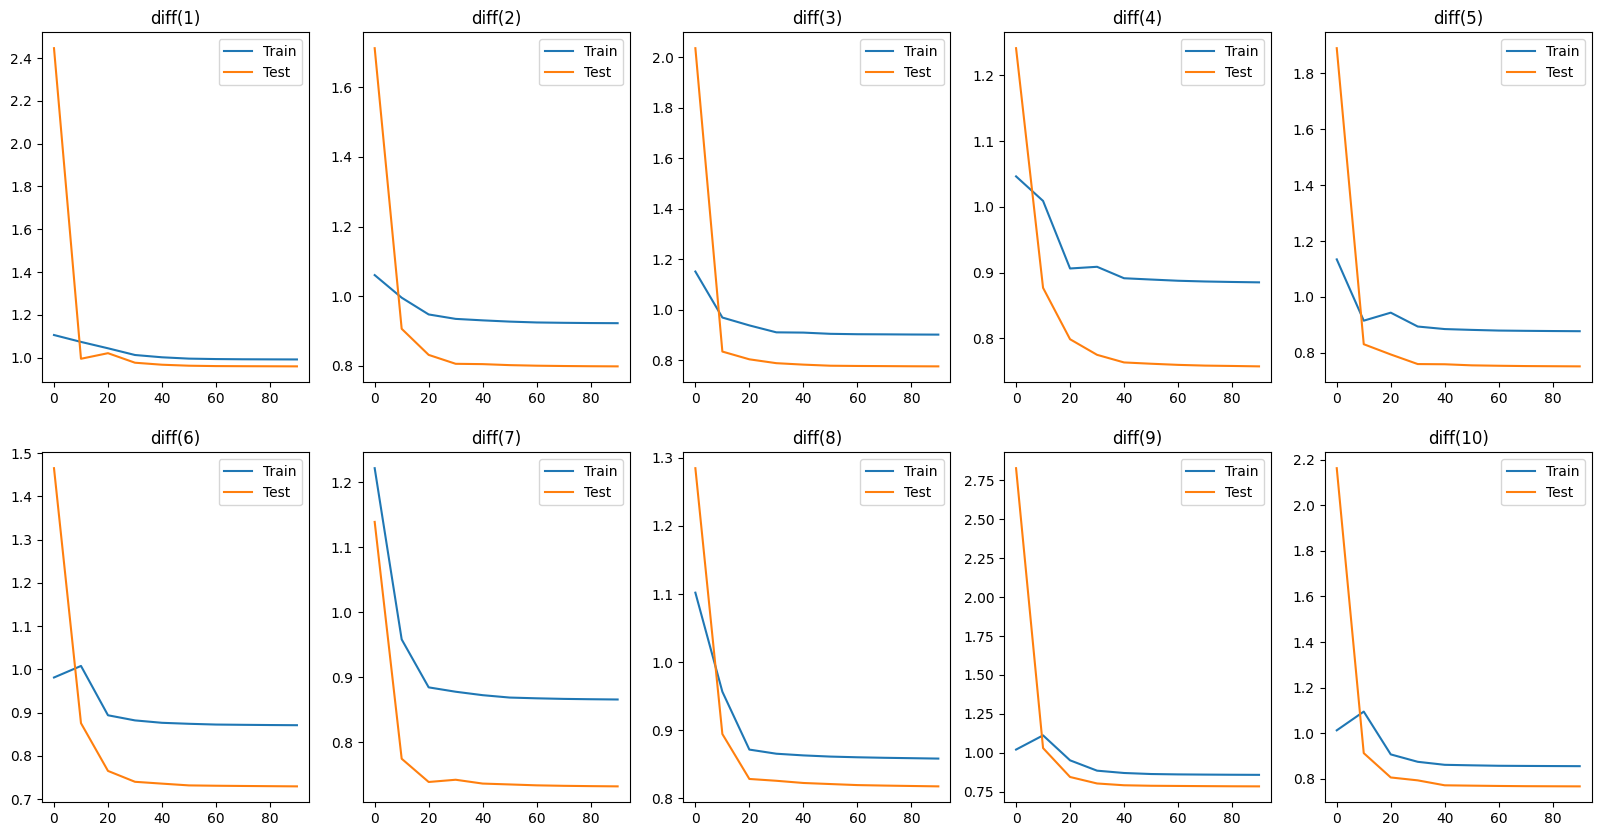

In [199]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for k in range(10) :
    axes[k//5][k%5].plot(ep_list[k], train_loss_list[k], label='Train')
    axes[k//5][k%5].plot(ep_list[k], test_loss_list[k], label='Test')
    axes[k//5][k%5].legend()
    axes[k//5][k%5].set_title(f'diff({k+1})')

plt.show()

# e. We can then evaluate our NN : 

In [235]:
from sklearn.metrics import r2_score

h_list = [k for k in range(1, 11)]
score_train = {}
Y_train_pred_list = {}

for k in range(10):
    Y_train_pred = Y_scaler_s[k].inverse_transform(model_list[k](X_train_norm).detach().numpy())

    Y_train_pred_list[k] = pd.Series(Y_train_pred.flatten())

    score_train[k] = r2_score(Y_train[:, k], Y_train_pred)

reg_lin_scores = pd.DataFrame.from_dict(scores, orient='index', columns=['R2'])
nn_score_train = pd.DataFrame.from_dict(score_train, orient='index', columns=['R2'])

In [236]:
Y_pred_df = pd.DataFrame()
for k in range(10):
    Y_pred_df[f'diff({k+1})'] = Y_train_pred_list[k]

Y_true_df = pd.DataFrame()
for k in range(10):
    Y_true_df[f'diff({k+1})'] = Y_train[:, k]

Imbalance_df = pd.DataFrame()
Imbalance_df['Imbalance'] = X_train[:, 0].detach().numpy()

df_total_true = pd.concat([Imbalance_df, Y_true_df], axis=1)
df_total_pred = pd.concat([Imbalance_df, Y_pred_df], axis=1)

df_total_true_groupby = df_total_true.groupby('Imbalance').mean()
df_total_pred_groupby = df_total_pred.groupby('Imbalance').mean()

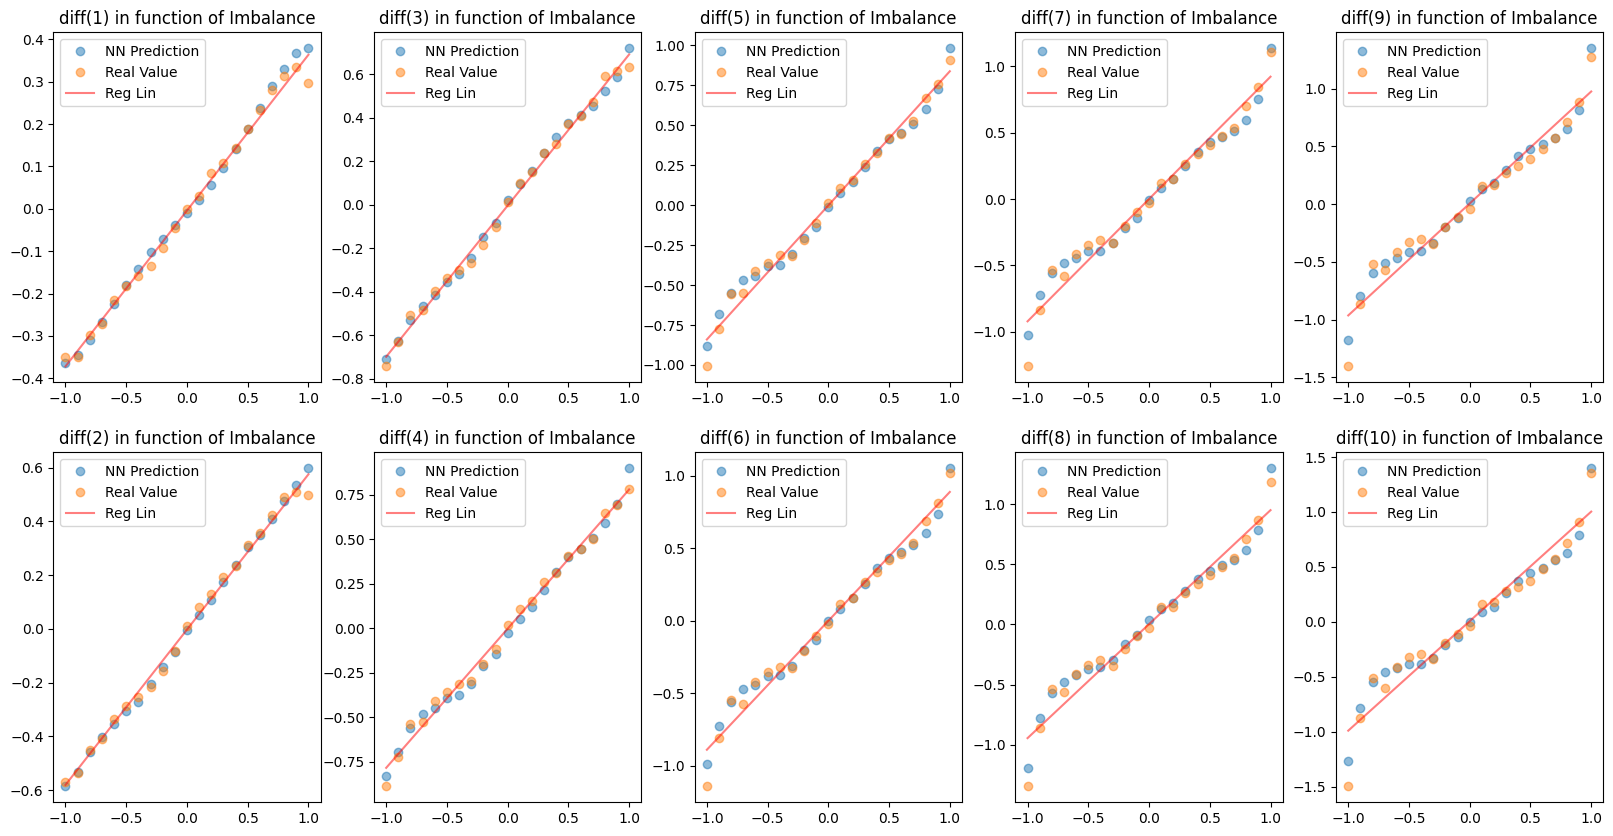

In [237]:
scores_NN = {}
scores_reglin = {}

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for k in range(10) :
    
  #NN
  axes[k%2,k//2].plot(df_total_pred_groupby.index, df_total_pred_groupby[f'diff({k+1})'], label='NN Prediction', marker='o', linestyle='None', alpha=0.5)
  axes[k%2,k//2].legend()
  axes[k%2,k//2].set_title(f'NN prediction : diff({k+1}) in function of Imbalance')

  scores_NN[f'diff({k+1})'] = r2_score(df_total_true_groupby[f'diff({k+1})'], df_total_pred_groupby[f'diff({k+1})'])

  #Reg lin
  axes[k%2,k//2].plot(df_total_true_groupby.index, df_total_true_groupby[f'diff({k+1})'], label='Real Value', marker='o', linestyle='None', alpha=0.5)
  
  x_ref = df_total_true_groupby.index
  y_ref = df_total_true_groupby[f'diff({k+1})']
  coef, intercept, score = reglin(np.array(x_ref), np.array(y_ref))
  axes[k%2,k//2].plot(np.array(x_ref), coef * np.array(x_ref) + intercept, color='red', label='Reg Lin', alpha=0.5)
  axes[k%2,k//2].legend()
  axes[k%2,k//2].set_title(f'diff({k+1}) in function of Imbalance')

  scores_reglin[f'diff({k+1})'] = score
plt.show()

Visually, we can see that the NN is able to capture the tangent-like shape of the curve. Notably, we can see that the NN significantly outperforms the linear regression for larger values of h.

- We compare the $R^2$ score : 

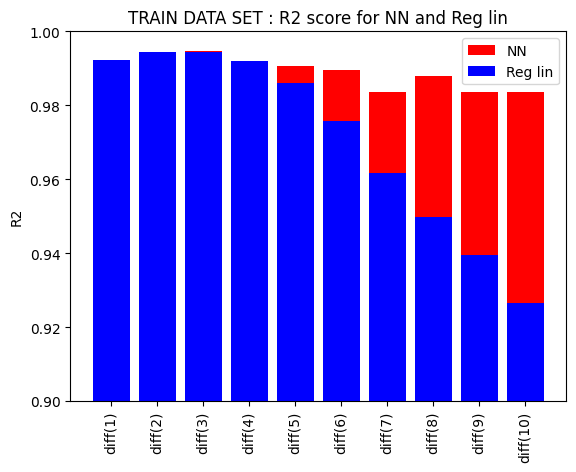

In [238]:
plt.bar(scores_NN.keys(), scores_NN.values(), label='NN', color='red')
plt.bar(scores_reglin.keys(), scores_reglin.values(), label='Reg lin', color='blue')
plt.title('TRAIN DATA SET : R2 score for NN and Reg lin')
plt.xticks(rotation=90)
plt.ylabel('R2')
plt.ylim(0.90, 1.0)
plt.legend()

In [239]:
for score in scores_NN:
    print(f"{score} - R2 | NN {scores_NN[score].round(4)} | R2 Reg lin : {scores_reglin[score].round(4)}")

diff(1) - R2 | NN 0.989 | R2 Reg lin : 0.9924
diff(2) - R2 | NN 0.9942 | R2 Reg lin : 0.9943
diff(3) - R2 | NN 0.9947 | R2 Reg lin : 0.9946
diff(4) - R2 | NN 0.9916 | R2 Reg lin : 0.9921
diff(5) - R2 | NN 0.9906 | R2 Reg lin : 0.986
diff(6) - R2 | NN 0.9897 | R2 Reg lin : 0.9757
diff(7) - R2 | NN 0.9835 | R2 Reg lin : 0.9616
diff(8) - R2 | NN 0.9879 | R2 Reg lin : 0.9497
diff(9) - R2 | NN 0.9836 | R2 Reg lin : 0.9396
diff(10) - R2 | NN 0.9837 | R2 Reg lin : 0.9265


We can clearly see that our NN outperforms linear regression on the training dataset.

# f. Model Evaluation on the Test Set : 

In [244]:
h_list = [k for k in range(1, 11)]
score_test = {}
Y_test_pred_list = {}

for k in range(10):
    Y_test_pred = Y_scaler_s[k].inverse_transform(model_list[k](X_test_norm).detach().numpy())

    Y_test_pred_list[k] = pd.Series(Y_test_pred.flatten())

    score_test[k] = r2_score(Y_test[:, k], Y_test_pred)

reg_lin_scores = pd.DataFrame.from_dict(scores, orient='index', columns=['R2'])
nn_scores_test = pd.DataFrame.from_dict(score_test, orient='index', columns=['R2'])

In [245]:
Y_pred_df = pd.DataFrame()
for k in range(10):
    Y_pred_df[f'diff({k+1})'] = Y_test_pred_list[k]

Y_true_df = pd.DataFrame()
for k in range(10):
    Y_true_df[f'diff({k+1})'] = Y_test[:, k]

Imbalance_df = pd.DataFrame()
Imbalance_df['Imbalance'] = X_test[:, 0].detach().numpy()

df_total_true = pd.concat([Imbalance_df, Y_true_df], axis=1)
df_total_pred = pd.concat([Imbalance_df, Y_pred_df], axis=1)

df_total_true_groupby = df_total_true.groupby('Imbalance').mean()
df_total_pred_groupby = df_total_pred.groupby('Imbalance').mean()

# g. Analysis of Results (Test set)

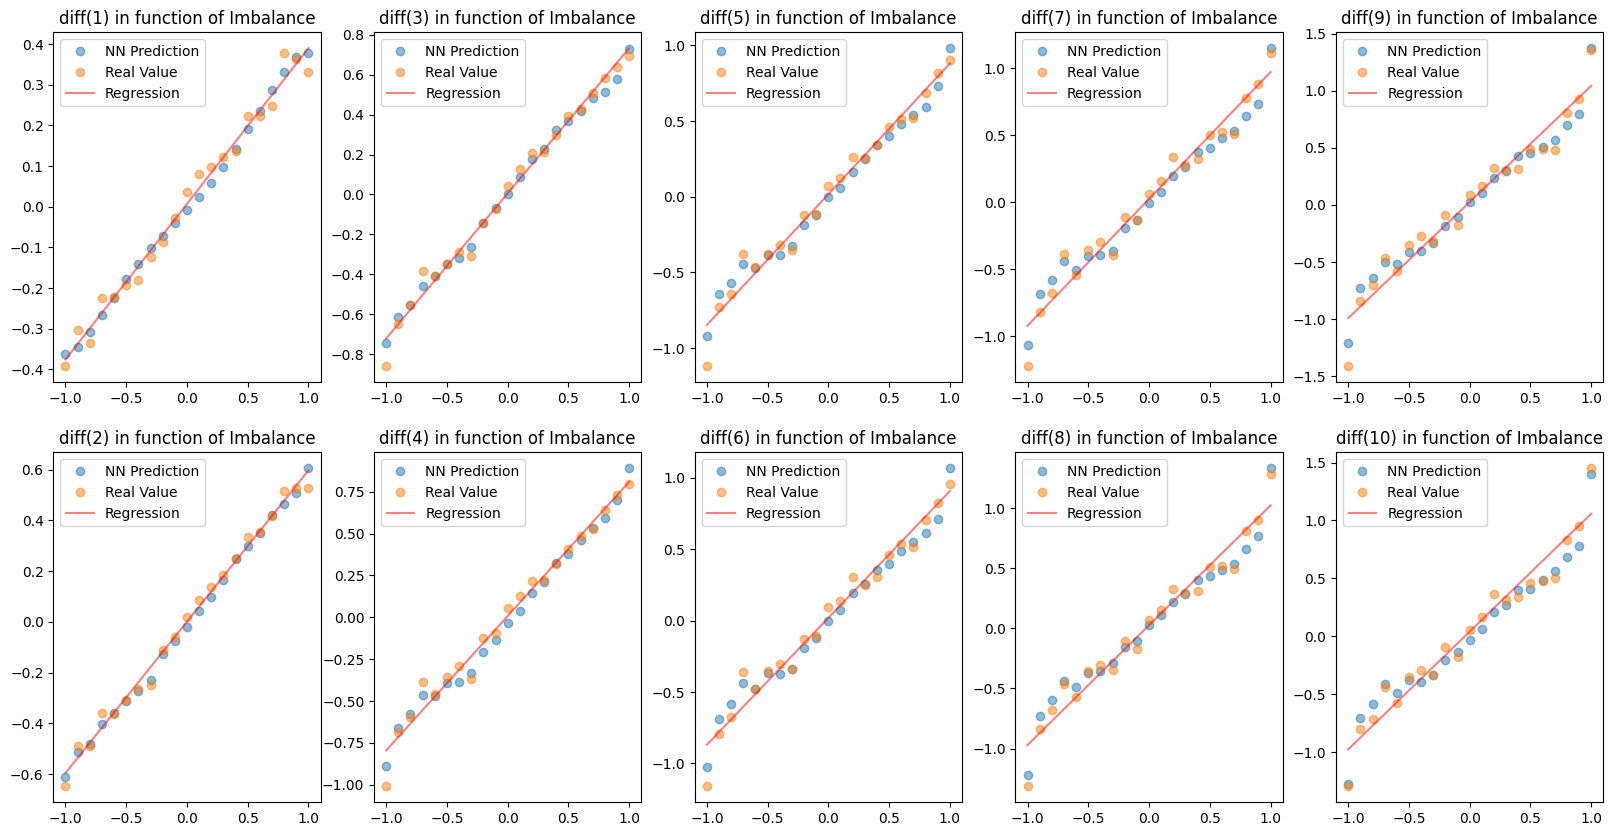

In [246]:
scores_NN = {}
scores_reglin = {}

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for k in range(10) :
    
  #NN
  axes[k%2,k//2].plot(df_total_pred_groupby.index, df_total_pred_groupby[f'diff({k+1})'], label='NN Prediction', marker='o', linestyle='None', alpha=0.5)
  axes[k%2,k//2].legend()
  axes[k%2,k//2].set_title(f'NN prediction : diff({k+1}) in function of Imbalance')

  scores_NN[f'diff({k+1})'] = r2_score(df_total_true_groupby[f'diff({k+1})'], df_total_pred_groupby[f'diff({k+1})'])

  #Reg lin
  axes[k%2,k//2].plot(df_total_true_groupby.index, df_total_true_groupby[f'diff({k+1})'], label='Real Value', marker='o', linestyle='None', alpha=0.5)
  
  x_ref = df_total_true_groupby.index
  y_ref = df_total_true_groupby[f'diff({k+1})']
  coef, intercept, score = reglin(np.array(x_ref), np.array(y_ref))
  axes[k%2,k//2].plot(np.array(x_ref), coef * np.array(x_ref) + intercept, color='red', label='Regression', alpha=0.5)
  axes[k%2,k//2].legend()
  axes[k%2,k//2].set_title(f'diff({k+1}) in function of Imbalance')

  scores_reglin[f'diff({k+1})'] = score
plt.show()

- Similarly to the training dataset, the NN seems to follow the tangent-like curve better than linear regression, especially for larger values of $h$.

- We compare the $R^2$ score for the `TEST SET` : 

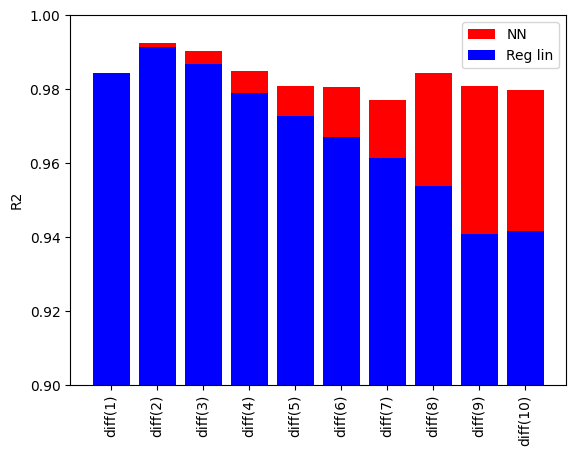

In [247]:
plt.bar(scores_NN.keys(), scores_NN.values(), label='NN', color='red')
plt.bar(scores_reglin.keys(), scores_reglin.values(), label='Reg lin', color='blue')
plt.xticks(rotation=90)
plt.ylabel('R2')
plt.ylim(0.90, 1.0)
plt.legend()

In [248]:
for score in scores_NN:
    print(f"{score} - R2 | NN {scores_NN[score].round(4)} | R2 Reg lin : {scores_reglin[score].round(4)}")

diff(1) - R2 | NN 0.9806 | R2 Reg lin : 0.9845
diff(2) - R2 | NN 0.9925 | R2 Reg lin : 0.9915
diff(3) - R2 | NN 0.9905 | R2 Reg lin : 0.9868
diff(4) - R2 | NN 0.9849 | R2 Reg lin : 0.9789
diff(5) - R2 | NN 0.9809 | R2 Reg lin : 0.9728
diff(6) - R2 | NN 0.9806 | R2 Reg lin : 0.9672
diff(7) - R2 | NN 0.977 | R2 Reg lin : 0.9615
diff(8) - R2 | NN 0.9844 | R2 Reg lin : 0.9537
diff(9) - R2 | NN 0.9809 | R2 Reg lin : 0.9408
diff(10) - R2 | NN 0.9797 | R2 Reg lin : 0.9418


- Based on the results above, the NN generally outperforms the linear regression from part 1.

- However, linear regression is slightly better for the horizon $h=1$.

To improve the result, we can:

- Find a better architecture for the NN.
- Fine-tune the parameters of the NN, such as the learning rate and the number of epochs.
- Try stochastic gradient descent with a batch size.
- Add features from the order book.
- Perform feature engineering by creating new features.

---